# Import Python Packages

In [ ]:
import json
import pandas as pd
import math
from tqdm import tqdm 
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
from os import listdir
from os.path import isfile, join

import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests
  
from sklearn import decomposition    
from sklearn.preprocessing import MinMaxScaler

# Load Data

In [41]:
def load_data(img_dir):
    file_lst = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
    data = np.concatenate([np.load(img_dir+f) for f in file_lst])
    print(data.shape)
    return data

real_img_dir = "/content/drive/MyDrive/111 Rendered.ai/data/cropped_data_for_latent_models/real/"
syn_img_dir = "/content/drive/MyDrive/111 Rendered.ai/data/cropped_data_for_latent_models/synthetic/"
real_data = load_data(real_img_dir)
syn_data = load_data(syn_img_dir)

(489, 316, 316, 3)
(489, 316, 316, 3)


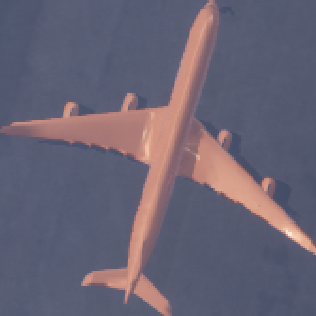

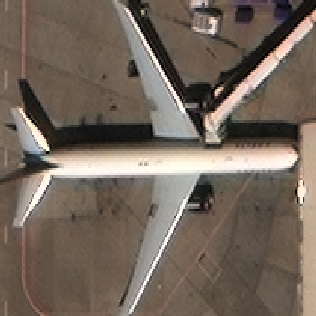

In [46]:
cv2_imshow(syn_data[0]);cv2_imshow(real_data[0])

In [48]:
num_samples, width, height, n_channel = real_data.shape

# Data Processing

In [51]:
def flat_and_center_data(data):
    num_samples, width, height, n_channel = data.shape
    # flatten the img
    flat_data = data.reshape(num_samples, -1)
    # centering
    min_max_scaler = MinMaxScaler()
    flat_data_centered = min_max_scaler.fit_transform(flat_data)
    return flat_data_centered, width, height

In [53]:
data_syn, width, height = flat_and_center_data(real_data)
data_real, _, _ = flat_and_center_data(syn_data)
data_syn.shape, data_real.shape

((489, 299568), (489, 299568))

In [71]:
# flat_data = real_data.reshape(num_samples, -1)
# plt.imshow(((flat_data-flat_data.mean())/flat_data.std())[0].reshape(316,316,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


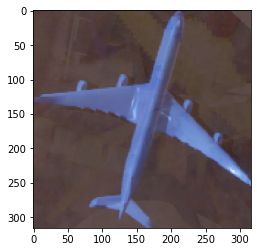

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


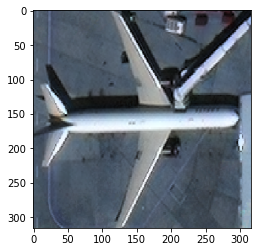

In [61]:
# visualize standardized data
plt.imshow(data_real[0].reshape(width,height,3));plt.show();plt.imshow(data_syn[0].reshape(width,height,3))

# PCA

In [ ]:
#Reducing dimension into n components
n_components_ = 9
pca = decomposition.PCA(n_components=n_components_, whiten=True)
pca.fit(data_real)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [ ]:
data_real.shape

(489, 299568)

[0.50849477 0.54282573 0.57004516 0.5954091  0.61212675 0.62818197
 0.64370342 0.65704311 0.66959169]


0.6695916882201661

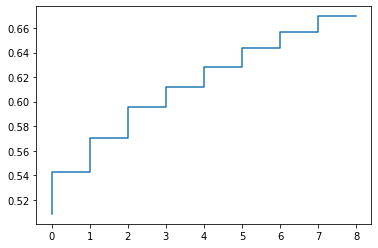

In [ ]:
#Cumulative sum of varience ratio of all components
exp_var_cum=np.cumsum(pca.explained_variance_ratio_)
print(exp_var_cum)
plt.step(range(exp_var_cum.size), exp_var_cum)
exp_var_cum[8]

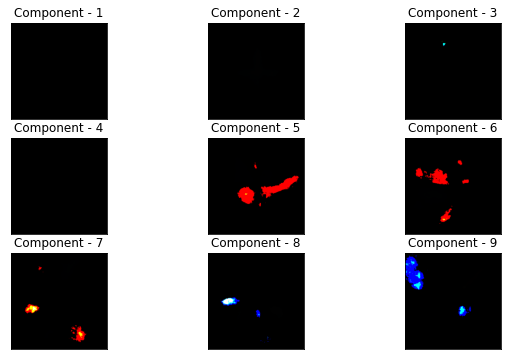

In [ ]:
#Lets see the components from PCA
fig, ax = plt.subplots(3,3, figsize=(10,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(9):
    pixels = pca.components_[i].reshape(width, height, n_channel)
    # print(pixels.min(),pixels.max())
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels_rgb, cmap='Blues')
    ax[i].set_title("Component - " + str(i+1))

# NMF

reference: http://www.columbia.edu/~jwp2128/Teaching/E4903/papers/nmf_nature.pdf

In [ ]:
#Reducing dimension into n components
n_components = 24
nmf = decomposition.NMF(n_components = n_components, init = 'random', tol=5e-3)    
W = nmf.fit_transform(data_real)
H = nmf.components_

In [ ]:
data.shape, flat_data_centered.shape, W.shape, H.shape

((5, 168, 168, 3), (5, 84672), (489, 24), (24, 299568))

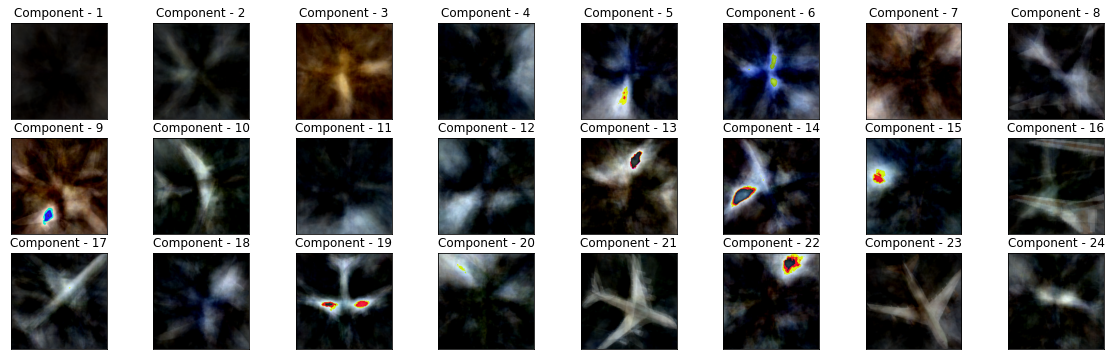

In [ ]:
# Lets see the components from NMF
fig, ax = plt.subplots(3, 8, figsize=(20,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(24):
    pixels = H[i]
    # print(pixels.min(), pixels.max())
    pixels = pixels.reshape(width, height, n_channel)
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels_rgb)
    ax[i].set_title("Component - " + str(i+1))

## Tuning k number of components

In [ ]:
# tuning k num_components
losses=[]
Hs = []
max_components = 30
for k in tqdm(range(2,max_components)):
    nmf = decomposition.NMF(n_components = k, init = 'random', tol=5e-3)    
    W = nmf.fit_transform(flat_data_centered)
    H = nmf.components_
    Hs.append(H)
    loss = np.linalg.norm(W.dot(H)-flat_data_centered)
    losses.append(loss)

Text(0.5, 0, 'k: Number of Components')

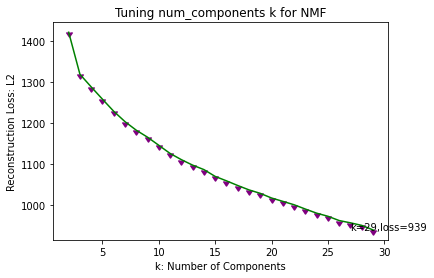

In [ ]:
plt.plot(range(2,30), losses, color="green")
plt.scatter(range(2,30), losses, marker=11, color="purple")
a=np.array(losses);
min_indx=np.argmin(a)#min value index
show_min='k='+str(min_indx+2)+',loss='+str(a[min_indx])[:3]
plt.annotate(show_min,xytext=(min_indx,a[min_indx]),xy=(min_indx,a[min_indx]))
plt.title("Tuning num_components k for NMF")
plt.ylabel("Reconstruction Loss: L2")
plt.xlabel("k: Number of Components")

In [ ]:
losses[22]

980.120627054412

k=24

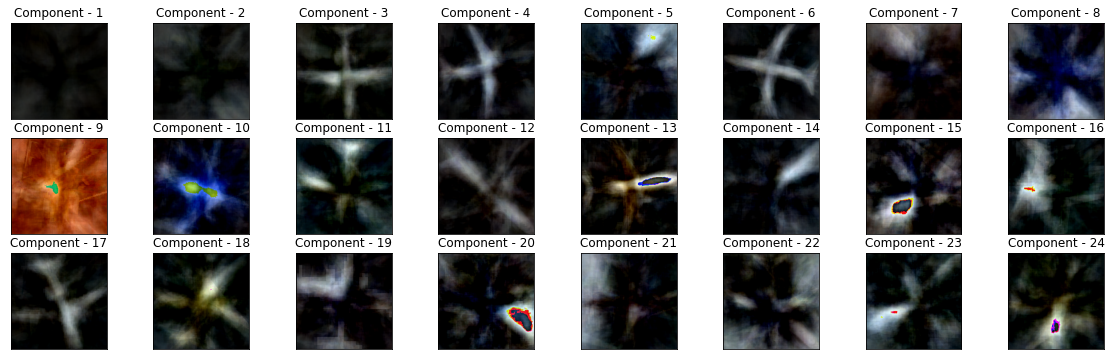

In [ ]:
# Lets see the components from NMF
fig, ax = plt.subplots(3, 8, figsize=(20,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
H = Hs[22]
for i in range(24):
    pixels = H[i]
    # print(pixels.min(), pixels.max())
    pixels = pixels.reshape(width, height, n_channel)
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels_rgb)
    ax[i].set_title("Component - " + str(i+1))

k=29

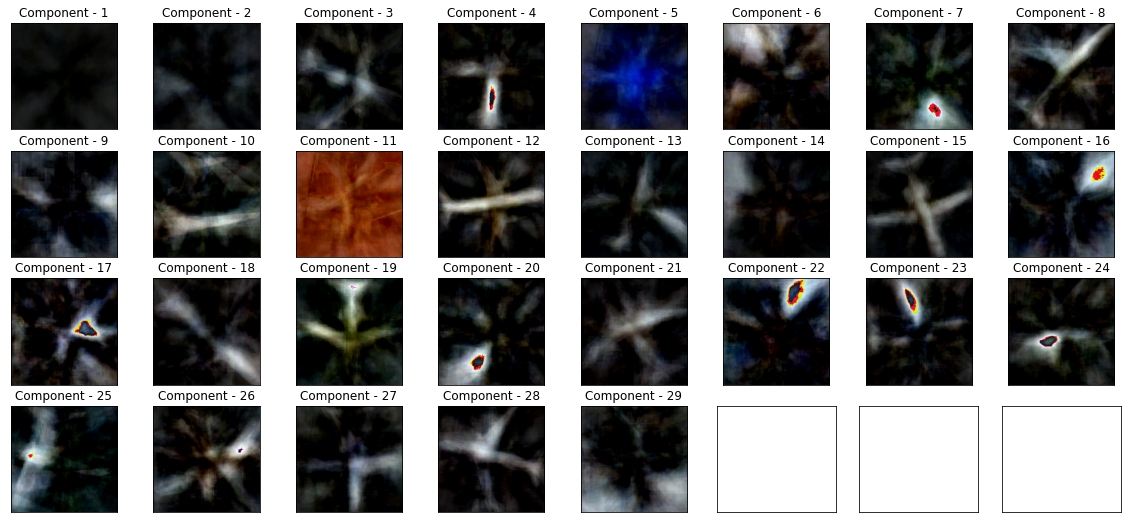

In [ ]:
# Lets see the components from NMF
fig, ax = plt.subplots(4, 8, figsize=(20,9), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
H = Hs[min_indx]
for i in range(min_indx+2):
    pixels = H[i]
    # print(pixels.min(), pixels.max())
    pixels = pixels.reshape(width, height, n_channel)
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels_rgb)
    ax[i].set_title("Component - " + str(i+1))

k=9

In [ ]:
losses[7]

1165.4367318331917

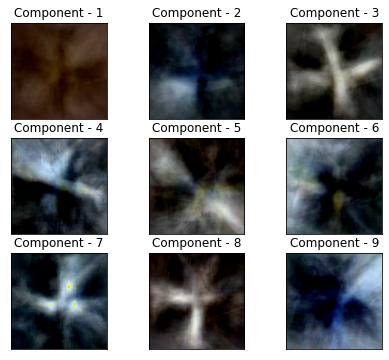

In [ ]:
# Lets see the components from NMF
fig, ax = plt.subplots(3, 3, figsize=(7,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
H = Hs[7]
for i in range(9):
    pixels = H[i]
    # print(pixels.min(), pixels.max())
    pixels = pixels.reshape(width, height, n_channel)
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels_rgb)
    ax[i].set_title("Component - " + str(i+1))

## Show projections from Syn on Real Hidden Space

In [ ]:
data_real.shape, data_syn.shape

((499, 243675), (499, 243675))

In [ ]:
def nmf_modeling(data_real, data_syn):
    # Reducing dimension into n components
    n_components = 24
    nmf = decomposition.NMF(n_components = n_components, init = 'random', tol=5e-3)    
    W = nmf.fit_transform(data_real)
    H = nmf.components_

    # project syn_data into hidden space.
    H_syn = W.T.dot(data_syn)
    return W, H, H_syn

In [ ]:
W_real, H_real, H_syn2real = nmf_modeling(data_real, data_syn)
W_syn, H_syn, H_real2syn = nmf_modeling(data_syn, data_real)

In [ ]:
def visualize_hidden_24(H):
    fig, ax = plt.subplots(3, 8, figsize=(20,6), subplot_kw={'xticks':(), 'yticks': ()})
    ax = ax.ravel()
    for i in range(24):
        pixels = H[i]
        # print(pixels.min(), pixels.max())
        pixels = pixels.reshape(width, height, n_channel)
        pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
        ax[i].imshow(pixels_rgb)
        ax[i].set_title("Component - " + str(i+1))

Visualize real data latent variables:


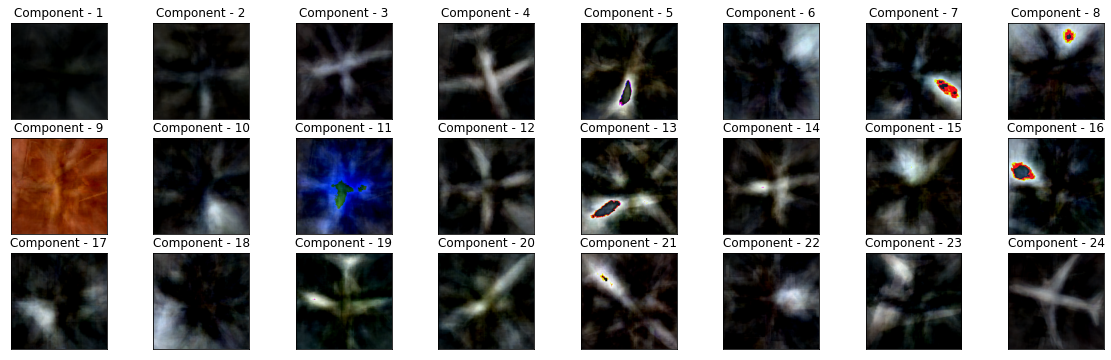

In [ ]:
print("Visualize real data latent variables:")
visualize_hidden_24(H_real)

Synthetic data project to real hidden space:


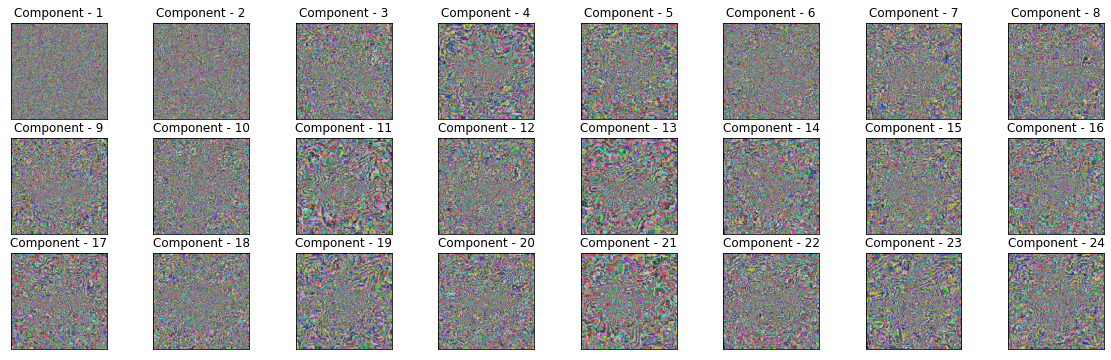

In [ ]:
print("Synthetic data project to real hidden space:")
visualize_hidden_24(H_syn2real)

Visualize syn data latent variables:


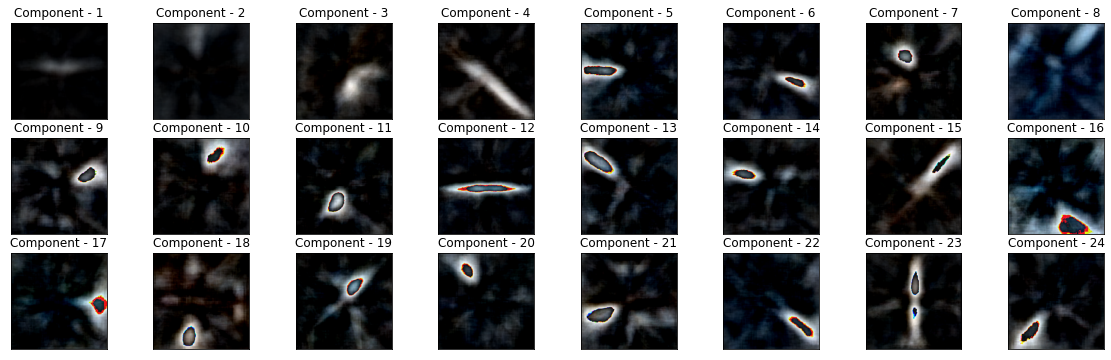

In [ ]:
print("Visualize syn data latent variables:")
visualize_hidden_24(H_syn)

Real data project to synthetic hidden space:


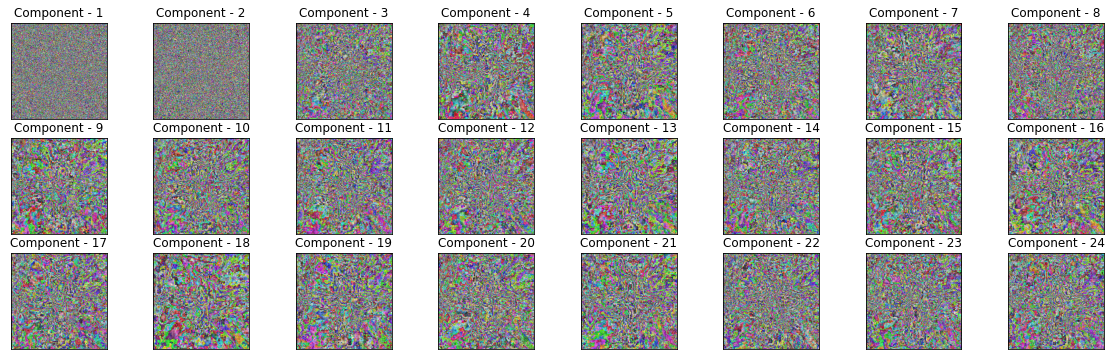

In [ ]:
print("Real data project to synthetic hidden space:")
visualize_hidden_24(H_real2syn)

## Clustering

In [ ]:
W_syn2real = data_syn.dot(H_real.T)
W_real2syn = data_real.dot(H_syn.T)

In [ ]:
def scatter_plotting(W_syn, W):
    plt.scatter(W_syn[:,0], W_syn[:,1], color="purple")
    plt.scatter(W[:,0], W[:,1], color="green")
    plt.show()
    plt.scatter(W[:,0], W[:,1], color="green")

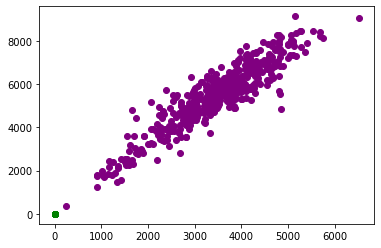

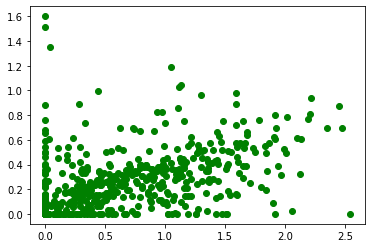

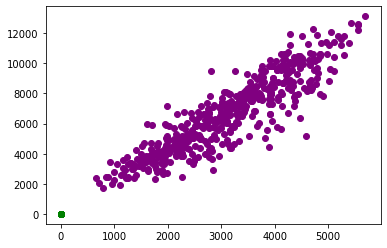

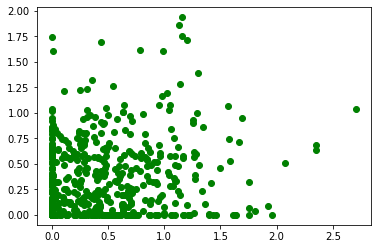

In [ ]:
scatter_plotting(W_syn2real, W_real);plt.show()
scatter_plotting(W_real2syn, W_syn)

In [ ]:
def get_reconstructed_data(W_syn2real, W_real):
    num_samples = data_real.shape[0]
    reconstructed_data = np.concatenate([W_syn2real, W_real], axis=0)
    labels = np.concatenate([np.ones((num_samples,1)), np.zeros((num_samples,1))], axis=0)
    df = pd.DataFrame(np.concatenate([reconstructed_data, labels], axis=1))
    return reconstructed_data, labels, df

In [ ]:
import plotly.express as px
def show_scatter_plots(df1, labels1):
    fig = px.scatter_matrix(
        df1,
        labels=labels1,
        dimensions=range(4),
        color=df1[[df1.columns[-1]]]
    )
    fig.update_traces(diagonal_visible=False)
    fig.show()

In [ ]:
reconstructed_data1, labels1, df1 = get_reconstructed_data(W_syn2real, W_real)
reconstructed_data2, labels2, df2 = get_reconstructed_data(W_real2syn, W_syn)

In [ ]:
show_scatter_plots(df1, labels1)

/usr/local/lib/python3.6/dist-packages/plotly/express/_core.py:79: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



In [ ]:
show_scatter_plots(df2, labels2)

/usr/local/lib/python3.6/dist-packages/plotly/express/_core.py:79: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

